In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Funciones Personalizadas
from utils.synthetic_features import temporada_alta
from utils.synthetic_features import periodo_dia

# Configuración General
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 8})

In [2]:
df = pd.read_csv('../data/dataset_SCL.csv')

/var/folders/q4/hqn7rgnd2776w9b_lc4r0vlr0000gn/T/ipykernel_10642/3157898594.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/dataset_SCL.csv')


In [3]:
# Transformar variables de fecha de string a datetime para cálculo de nuevas variables
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# Agregar Variable Fecha
df['fecha'] = df['Fecha-I'].dt.date

# Nuevas Variables: Temporada
df['temporada_alta'] = df['Fecha-I'].apply(temporada_alta)
df['temporada_alta_enriched'] = df['Fecha-I'].apply(temporada_alta, enriched=True)

# Nuevas Variables: Atraso en Minutos
df['dif_min'] = (df['Fecha-O'] - df['Fecha-I']).apply(lambda x: x.total_seconds() / 60)
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x>15 else 0)

# Nuevas Variables: Periodo del Día (mañana, tarde, noche)
df['periodo_dia'] = df['Fecha-I'].apply(periodo_dia)

# Dia de la semana en formato numérico (1: Lunes, 7: Domingo)
df['SEMANA'] = df['Fecha-O'].dt.strftime('%Y%W')
df['DOW'] = df['Fecha-O'].dt.dayofweek + 1

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fecha-I                  68206 non-null  datetime64[ns]
 1   Vlo-I                    68206 non-null  object        
 2   Ori-I                    68206 non-null  object        
 3   Des-I                    68206 non-null  object        
 4   Emp-I                    68206 non-null  object        
 5   Fecha-O                  68206 non-null  datetime64[ns]
 6   Vlo-O                    68205 non-null  object        
 7   Ori-O                    68206 non-null  object        
 8   Des-O                    68206 non-null  object        
 9   Emp-O                    68206 non-null  object        
 10  DIA                      68206 non-null  int64         
 11  MES                      68206 non-null  int64         
 12  AÑO                      68206 n

### Tratamiento de Datos

In [166]:
# Definición de Variable Dependiente
y = df.atraso_15

# Definición de Variables Independientes
X_columns = ['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'temporada_alta_enriched', 'periodo_dia']
X = df[X_columns]

print('y:', y.shape)
print('X:', X.shape)

y: (68206,)
X: (68206, 7)


In [167]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=20230214)

In [168]:
X_train

,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,temporada_alta_enriched,periodo_dia
53449,10,Domingo,N,Grupo LATAM,La Serena,0,mañana
44962,9,Viernes,I,Oceanair Linhas Aereas,Sao Paulo,0,tarde
67972,12,Viernes,N,JetSmart SPA,Antofagasta,0,noche
25962,5,Miercoles,N,Grupo LATAM,Calama,0,tarde
27285,5,Miercoles,N,Latin American Wings,Puerto Montt,0,tarde
...,...,...,...,...,...,...,...
11868,3,Jueves,I,Aerolineas Argentinas,Buenos Aires,0,mañana
61510,11,Martes,I,Latin American Wings,Lima,0,tarde
63207,12,Viernes,N,Sky Airline,Puerto Montt,0,mañana
14712,3,Viernes,N,Grupo LATAM,Concepcion,0,tarde


In [170]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False, min_frequency=100, handle_unknown='infrequent_if_exist')
encoder.fit(X_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [171]:
X_train_encoded.shape

(45698, 84)

### Naive Model (wo Hyperparameter Tuning)

In [172]:
from sklearn.linear_model import LogisticRegression

In [173]:
lr = LogisticRegression(max_iter=1000)

In [174]:
lr.fit(X_train_encoded, y_train)

LogisticRegression(max_iter=1000)

In [175]:
y_train_pred = lr.predict(X_train_encoded)
y_test_pred = lr.predict(X_test_encoded)

In [176]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train, y_pred=y_train_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     37198
           1       0.55      0.04      0.07      8500

    accuracy                           0.82     45698
   macro avg       0.69      0.52      0.48     45698
weighted avg       0.77      0.82      0.74     45698



In [177]:
print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18394
           1       0.56      0.04      0.08      4114

    accuracy                           0.82     22508
   macro avg       0.69      0.52      0.49     22508
weighted avg       0.77      0.82      0.75     22508



In [178]:
classification_report(y_true=y_test, y_pred=y_test_pred, output_dict=True)

{'0': {'precision': 0.8227180527383368,
  'recall': 0.9922800913341306,
  'f1-score': 0.8995785997683531,
  'support': 18394},
 '1': {'precision': 0.5603715170278638,
  'recall': 0.043996110841030625,
  'f1-score': 0.08158665765156638,
  'support': 4114},
 'accuracy': 0.8189532610627333,
 'macro avg': {'precision': 0.6915447848831002,
  'recall': 0.5181381010875806,
  'f1-score': 0.4905826287099597,
  'support': 22508},
 'weighted avg': {'precision': 0.7747664956069664,
  'recall': 0.8189532610627333,
  'f1-score': 0.7500664774177016,
  'support': 22508}}

### Naive Model (w Hyperparameter Tuning)

In [96]:
from sklearn.model_selection import RandomizedSearchCV

In [102]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['liblinear']
}

lr = LogisticRegression(max_iter=1000)
clf = RandomizedSearchCV(lr, parameters)
clf.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.814 total time=   0.1s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.816 total time=   0.1s
[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.815 total time=   0.1s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.815 total time=   0.1s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.816 total time=   0.1s
[CV 1/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.814 total time=   0.5s
[CV 2/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.815 total time=   0.6s
[CV 3/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.815 total time=   0.6s
[CV 4/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.815 total time=   0.7s
[CV 5/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.816 total time=   0.6s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.814 total time=   0.1s
[CV 2/5] END C=1.0, penalty=l2, solve

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   verbose=3)

In [105]:
clf.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}

In [179]:
lr = LogisticRegression(solver='liblinear', penalty='l2', C=1.0, max_iter=1000)
lr.fit(X_train_encoded, y_train)

y_train_pred = lr.predict(X_train_encoded)
y_test_pred = lr.predict(X_test_encoded)

print(classification_report(y_true=y_train, y_pred=y_train_pred))

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     37198
           1       0.55      0.04      0.07      8500

    accuracy                           0.82     45698
   macro avg       0.69      0.52      0.48     45698
weighted avg       0.77      0.82      0.74     45698

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18394
           1       0.56      0.04      0.08      4114

    accuracy                           0.82     22508
   macro avg       0.69      0.52      0.49     22508
weighted avg       0.77      0.82      0.75     22508



In [180]:
classification_report(y_true=y_test, y_pred=y_test_pred, output_dict=True)

{'0': {'precision': 0.8226809699810691,
  'recall': 0.9922800913341306,
  'f1-score': 0.8995564317397732,
  'support': 18394},
 '1': {'precision': 0.5590062111801242,
  'recall': 0.043753038405444825,
  'f1-score': 0.0811541929666366,
  'support': 4114},
 'accuracy': 0.8189088324151412,
 'macro avg': {'precision': 0.6908435905805966,
  'recall': 0.5180165648697878,
  'f1-score': 0.4903553123532049,
  'support': 22508},
 'weighted avg': {'precision': 0.7744866409555188,
  'recall': 0.8189088324151412,
  'f1-score': 0.7499693155893963,
  'support': 22508}}

In [181]:
# Coeficientes Modelo 1

coeficientes = pd.DataFrame(lr.coef_[0]).rename(columns={0:'Coeficiente'})
columnas = pd.DataFrame(encoder.get_feature_names_out()).rename(columns={0:'Atributo'})

sum_coef1 = pd.concat([columnas, coeficientes], axis=1)
sum_coef1['abs'] = abs(sum_coef1['Coeficiente'])
sum_coef1['color'] = np.where(sum_coef1['Coeficiente'] > 0, 'skyblue', 'lightsalmon')

sum_coef1 = sum_coef1.sort_values(by='abs',ascending=True)

Text(0.5, 1.0, 'Aporte de Cada Variable')

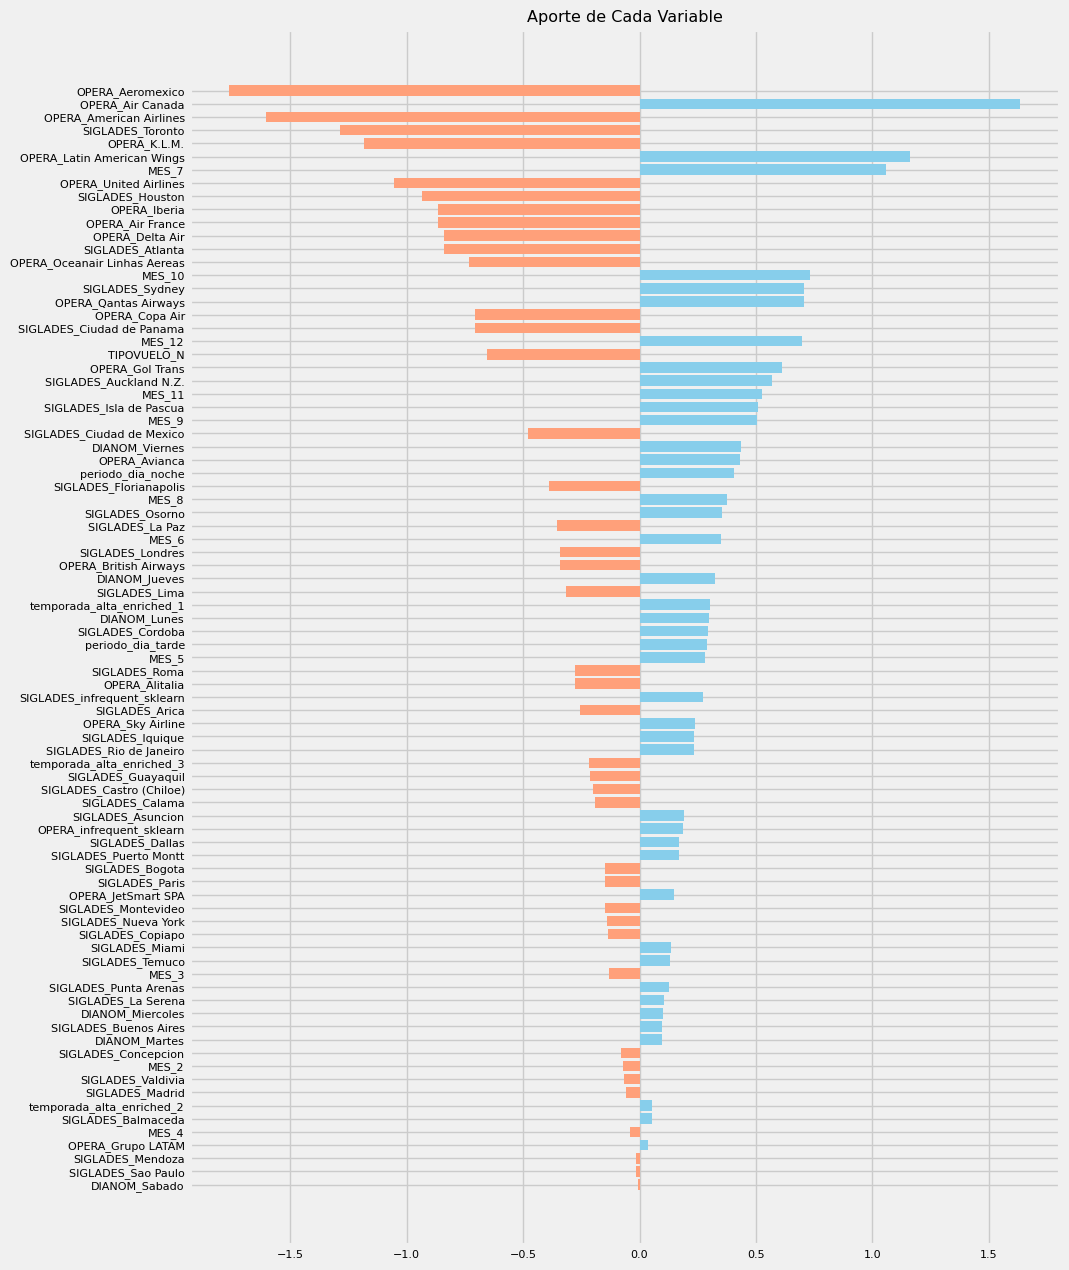

In [182]:
plt.figure(figsize=(10,15))
plt.barh(sum_coef1['Atributo'], sum_coef1['Coeficiente'], color=sum_coef1['color'])
plt.title('Aporte de Cada Variable')

### Naive Model (w Hyperparameter Tuning / wo OPERA)

In [375]:
from sklearn.preprocessing import OneHotEncoder

# Definición de Variable Dependiente
y = df.atraso_15

# Definición de Variables Independientes
X_columns = ['MES', 'DIANOM', 'TIPOVUELO', 'SIGLADES', 'temporada_alta_enriched', 'periodo_dia']
X_columns = ['MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'temporada_alta', 'periodo_dia']
X = df[X_columns]


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=20230214)

encoder = OneHotEncoder(drop='first', sparse_output=False, min_frequency=100, handle_unknown='infrequent_if_exist')
encoder.fit(X_train)

X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)


columns = ['MES_2',
 'MES_3',
 'MES_4',
 'MES_5',
 'MES_6',
 'MES_7',
 'MES_9',
 'MES_10',
 'MES_12',
 'DIANOM_Jueves',
 'DIANOM_Lunes',
 'DIANOM_Martes',
 'DIANOM_Miercoles',
 'DIANOM_Sabado',
 'DIANOM_Viernes',
 'TIPOVUELO_N',
 'SIGLADES_Arica',
 'SIGLADES_Asuncion',
 'SIGLADES_Atlanta',
 'SIGLADES_Auckland N.Z.',
 'SIGLADES_Balmaceda',
 'SIGLADES_Bogota',
 'SIGLADES_Buenos Aires',
 'SIGLADES_Calama',
 'SIGLADES_Castro (Chiloe)',
 'SIGLADES_Ciudad de Mexico',
 'SIGLADES_Ciudad de Panama',
 'SIGLADES_Concepcion',
 'SIGLADES_Copiapo',
 'SIGLADES_Cordoba',
 'SIGLADES_Dallas',
 'SIGLADES_Houston',
 'SIGLADES_La Serena',
 'SIGLADES_Lima',
 'SIGLADES_Melbourne',
 'SIGLADES_Mendoza',
 'SIGLADES_Nueva York',
 'SIGLADES_Paris',
 'SIGLADES_Puerto Natales',
 'SIGLADES_Punta Arenas',
 'SIGLADES_Punta Cana',
 'SIGLADES_Rio de Janeiro',
 'SIGLADES_Roma',
 'SIGLADES_Rosario',
 'SIGLADES_Sao Paulo',
 'SIGLADES_Sydney',
 'SIGLADES_Temuco',
 'SIGLADES_Toronto',
 'SIGLADES_Valdivia',
 'SIGLADES_infrequent_sklearn',
 'temporada_alta_enriched_2',
 'temporada_alta_enriched_3',
 'periodo_dia_noche',
 'periodo_dia_tarde']


X_train = X_train[columns]

In [387]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['liblinear']
}

lr = LogisticRegression(max_iter=1000)
clf = RandomizedSearchCV(lr, parameters)
clf.fit(X_train_encoded, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']})

In [388]:
clf.best_params_

{'solver': 'liblinear', 'penalty': 'l2', 'C': 1.0}

In [376]:
lr = LogisticRegression(solver='liblinear', penalty='l1', C=0.1, max_iter=1000)

In [389]:
clf.fit(X_train_encoded, y_train)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=1000),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']})

In [390]:
clf.predict_proba(X_test_encoded)

array([[0.86355098, 0.13644902],
       [0.82600004, 0.17399996],
       [0.88455513, 0.11544487],
       ...,
       [0.90356021, 0.09643979],
       [0.90549449, 0.09450551],
       [0.84453246, 0.15546754]])

In [378]:
y_train_pred = lr.predict(X_train_encoded)
y_test_pred = lr.predict(X_test_encoded)

print(classification_report(y_true=y_train, y_pred=y_train_pred))

print(classification_report(y_true=y_test, y_pred=y_test_pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     37198
           1       0.58      0.03      0.05      8500

    accuracy                           0.82     45698
   macro avg       0.70      0.51      0.47     45698
weighted avg       0.77      0.82      0.74     45698

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18394
           1       0.56      0.03      0.05      4114

    accuracy                           0.82     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.82      0.74     22508



In [403]:
from sklearn.metrics import roc_auc_score

## THRESHOLD
############################

probs_y_train = clf.predict_proba(X_train_encoded)

results = {'threshold':[], 'recall_score':[]}

for threshold in np.linspace(0,1,101):
    y_pred_threshold = np.where(probs_y_train[:,1] > threshold, 1, 0)
    
    results['threshold'].append(threshold)
    results['recall_score'].append(roc_auc_score(y_train, y_pred_threshold))

In [404]:
results_pd = pd.DataFrame(results)
threshold = results_pd.loc[results_pd['recall_score']== max(results_pd['recall_score']),:].reset_index().iloc[0,1]

In [405]:
threshold

0.17

In [406]:
results_pd.query(f'threshold == {threshold}')

,threshold,recall_score
17,0.17,0.627822


In [411]:
predicciones_finales = np.where(probs_y_train[:,1] > threshold, 1, 0)
print(classification_report(y_true=y_train, y_pred=predicciones_finales))

              precision    recall  f1-score   support

           0       0.89      0.57      0.70     37198
           1       0.27      0.68      0.38      8500

    accuracy                           0.59     45698
   macro avg       0.58      0.63      0.54     45698
weighted avg       0.77      0.59      0.64     45698



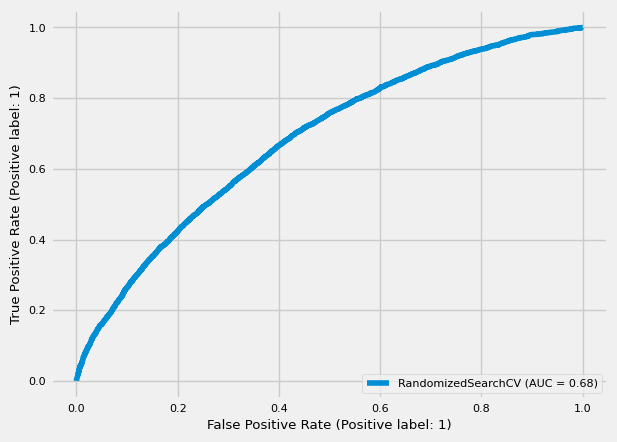

In [412]:
RocCurveDisplay.from_estimator(clf, X_test_encoded, y_test)

In [383]:
from sklearn.metrics import roc_curve, roc_auc_score

probs_y_test = lr.predict_proba(X_test_encoded)

fpr_1, tpr_1, th = roc_curve(y_test, probs_y_test[:,1])
auc_1 = roc_auc_score(y_test, probs_y_test[:,1])

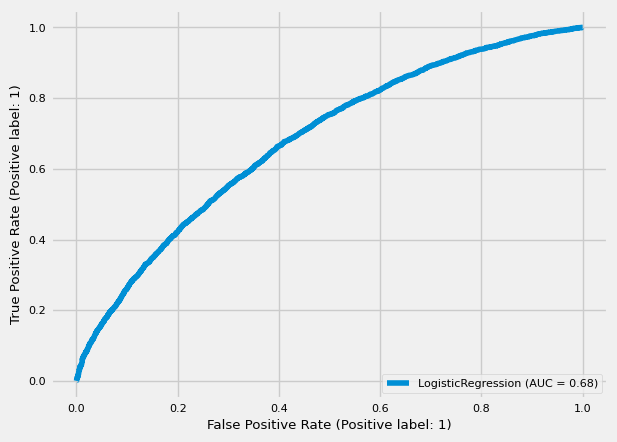

In [385]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(lr, X_test_encoded, y_test)
#RocCurveDisplay.from_estimator(xg_clf, X_test_encoded, y_test)
plt.show()

In [207]:
import xgboost as xgb

In [304]:
dtrain = xgb.DMatrix(X_train_encoded, label=y_train)
dtest = xgb.DMatrix(X_test_encoded, label=y_test)

In [305]:
xg_clf = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [306]:
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [312]:
xg_clf.fit(X_train_encoded,y_train)

preds = xg_clf.predict_proba(X_test_encoded)

In [313]:
preds

array([[0.69807607, 0.30192393],
       [0.71909845, 0.28090152],
       [0.72909683, 0.27090317],
       ...,
       [0.7128948 , 0.2871052 ],
       [0.7077266 , 0.2922734 ],
       [0.7183067 , 0.28169328]], dtype=float32)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

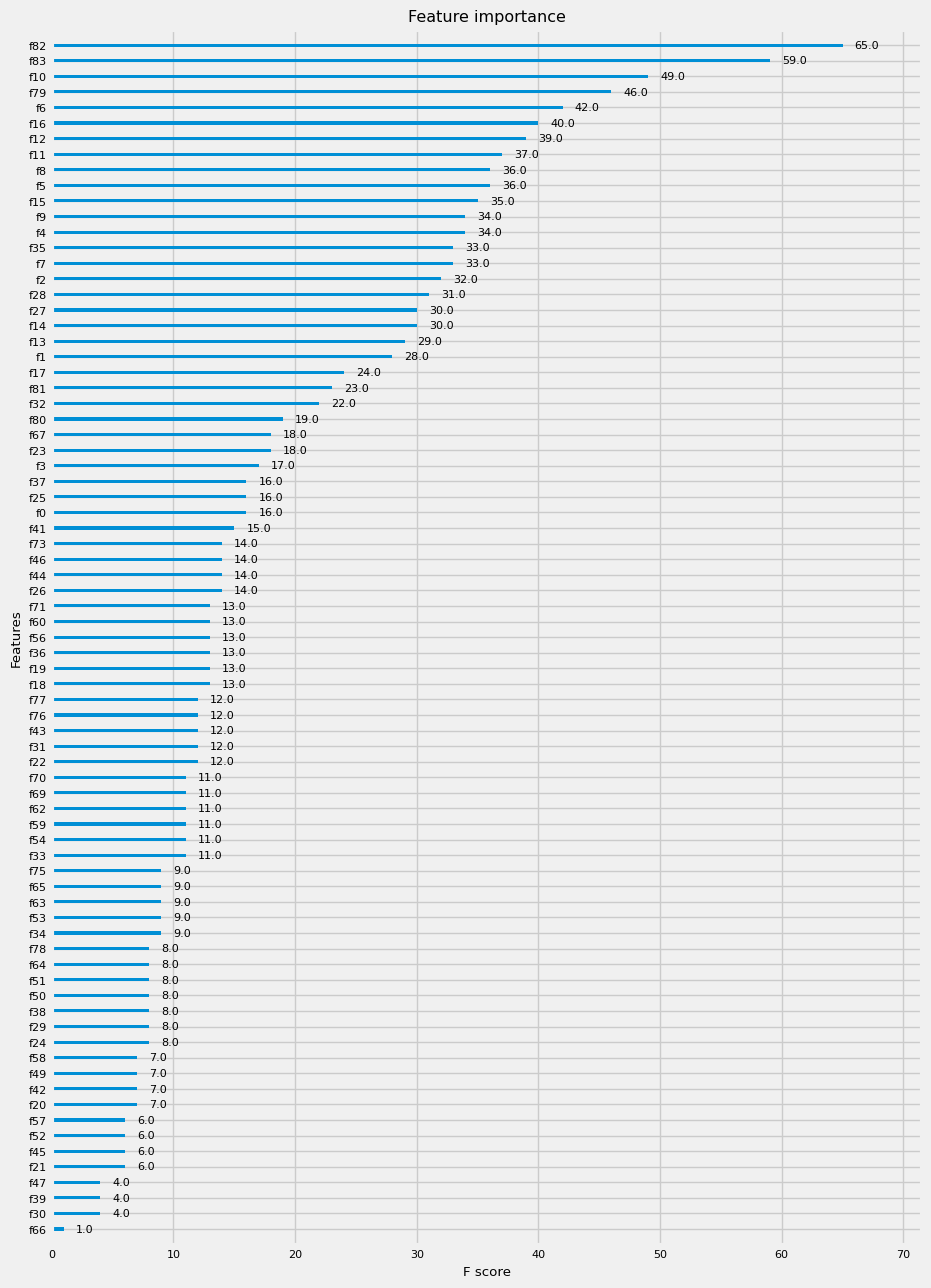

In [308]:
fig, ax = plt.subplots(figsize=(10,15))
xgb.plot_importance(bst, ax=ax)

In [392]:
from sklearn.metrics import recall_score

## THRESHOLD
############################

probs_y_train = lr.predict_proba(X_train_encoded)

results = {'threshold':[], 'recall_score':[]}

for threshold in np.linspace(0,1,101):
    y_pred_threshold = np.where(probs_y_train[:,1] > threshold, 1, 0)
    
    results['threshold'].append(threshold)
    results['recall_score'].append(recall_score(y_train, y_pred_threshold))

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [326]:
resultds_xgboost = pd.DataFrame(results)
threshold = resultds_xgboost[resultds_xgboost['Accuracy'] == resultds_xgboost['Accuracy'].max()].reset_index(drop=True)['threshold'][0]

In [345]:
from sklearn.metrics import roc_curve, roc_auc_score

probs_y_test = xg_clf.predict_proba(X_train_encoded)

fpr_1, tpr_1, th = roc_curve(y_train, probs_y_test[:,1])
auc_1 = roc_auc_score(y_train, probs_y_test[:,1])

ImportError: cannot import name 'roc_auc_binary' from 'sklearn.metrics' (/Users/ignaciotapia/workspace/neuralworks-desafio-ds/venv/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

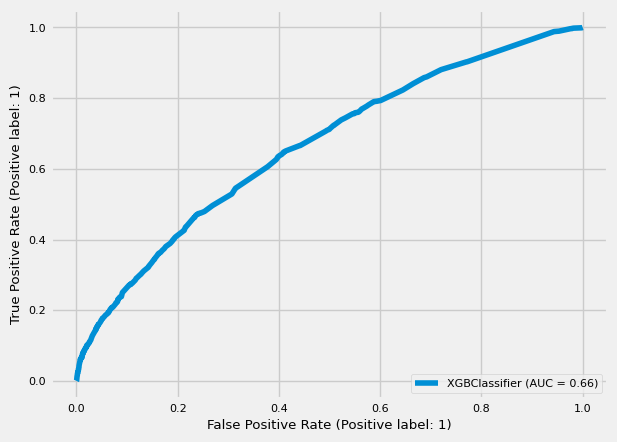

In [351]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(xg_clf, X_test_encoded, y_test)
plt.show()

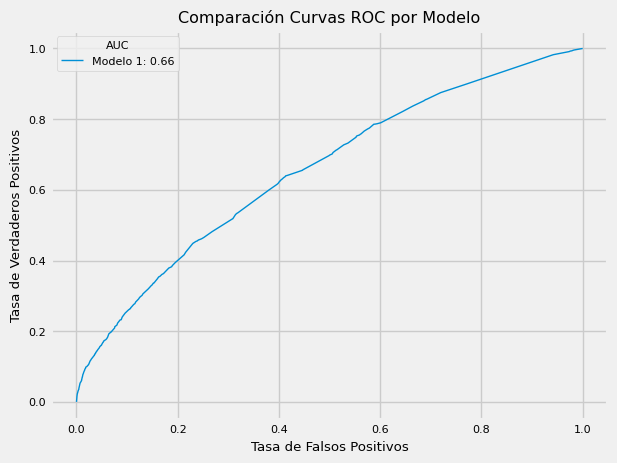

In [346]:
plt.plot(fpr_1, tpr_1, linewidth=1,label='Modelo 1: {}'.format(str(round(auc_1,2))))
plt.title('Comparación Curvas ROC por Modelo')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(title='AUC')
plt.show()

In [347]:
probs_df_pred = xg_clf.predict_proba(X_test_encoded)
predicciones_finales = np.where(probs_df_pred[:,1] > threshold, 1, 0)

In [342]:
print(classification_report(y_true=y_test, y_pred=predicciones_finales))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18394
           1       0.64      0.06      0.11      4114

    accuracy                           0.82     22508
   macro avg       0.73      0.53      0.50     22508
weighted avg       0.79      0.82      0.76     22508

